In [ ]:
"""
Experiment utilities for the EV Stag Hunt model.

Contains policy factory functions, trial runners, multiprocessing helpers,
and standalone plotting routines. Depends on `ev_core` for the model.
"""

from __future__ import annotations

import os
from typing import Callable, Dict, Optional, Tuple, List

import numpy as np
import pandas as pd
import matplotlib
import networkx as nx
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

from ev_core import (
    set_initial_adopters,
    final_mean_adoption_vs_ratio,
    phase_sweep_X0_vs_ratio,
)
from ev_plotting import (
    plot_fanchart,
    plot_spaghetti,
    plot_density,
    plot_ratio_sweep,
    plot_phase_plot,
)
from ev_experiments import (
    policy_subsidy_factory,
    policy_infrastructure_boost_factory,
    run_timeseries_trial,
    
)
from ev_core_new import (
    EVStagHuntModel, 
    set_initial_adopters,
    run_network_trial,
    final_mean_adoption_vs_I0,
    phase_sweep_X0_vs_I0,
)
from ev_experiments_new import (
    I0_sweep_df,
    phase_sweep_df_I0,
)
from ev_plotting_new import (
    plot_I0_sweep,
    plot_phase_plot_I0,
    _default_plot_path
)

In [18]:
# -----------------------------
# Policy factories
# -----------------------------

def policy_subsidy_factory(start: int, end: int, delta_a0: float = 0.3, delta_beta_I: float = 0.0) -> Callable:
    """Create a policy that temporarily boosts coordination payoffs.

    Raises `a0` and/or `beta_I` during `[start, end)` and reverts after.
    Returns a closure `policy(model, step)`.
    """

    def policy(model, step):
        if not hasattr(policy, "base_a0"):
            policy.base_a0 = model.a0
        if not hasattr(policy, "base_beta_I"):
            policy.base_beta_I = model.beta_I

        if start <= step < end:
            model.a0 = policy.base_a0 + delta_a0
            model.beta_I = policy.base_beta_I + delta_beta_I
        else:
            model.a0 = policy.base_a0
            model.beta_I = policy.base_beta_I

    return policy


def policy_infrastructure_boost_factory(start: int, boost: float = 0.2, once: bool = True) -> Callable:
    """Create a policy that injects infrastructure at a specific step."""

    def policy(model, step):
        if step < start:
            return
        if once:
            if not hasattr(policy, "done"):
                model.infrastructure = float(np.clip(model.infrastructure + boost, 0.0, 1.0))
                policy.done = True
        else:
            model.infrastructure = float(np.clip(model.infrastructure + boost, 0.0, 1.0))

    return policy


# -----------------------------
# Trial runner
# -----------------------------

def run_timeseries_trial(
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    seed: Optional[int] = None,
    policy: Optional[Callable] = None,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """Run a single simulation and return X(t), I(t), and the model dataframe."""

    scenario = {
        # Either provide `ratio` to pin the initial a_I/b, or explicit `a0`.
        # Defaults here mirror the classroom-friendly values.
        # If `ratio` is present, we compute `a0 = ratio*b - beta_I*I0`.
        "a0": 2.0,
        "ratio": None,
        "beta_I": 3.0,
        "b": 1.0,
        "g_I": 0.1,
        "I0": 0.05,
        "network_type": "BA",
        "n_nodes": 1000,
        "p": 0.05,
        "m": 2,
        "collect": True,
        "X0_frac": 0.0,
        "init_method": "random",
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    # Compute a0 from ratio if provided to preserve initial payoff ratio
    a0_for_model = scenario["a0"]
    if scenario.get("ratio") is not None:
        a0_for_model = float(scenario["ratio"]) * float(scenario["b"]) - float(scenario["beta_I"]) * float(scenario["I0"])

    model = EVStagHuntModel(
        a0=a0_for_model,
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        I0=scenario["I0"],
        seed=seed,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        collect=True,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    if scenario.get("X0_frac", 0.0) > 0.0:
        set_initial_adopters(
            model,
            scenario["X0_frac"],
            method=scenario.get("init_method", "random"),
            seed=seed,
        )

    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    df = model.datacollector.get_model_vars_dataframe().copy()
    return df["X"].to_numpy(), df["I"].to_numpy(), df


def _timeseries_trial_worker(args_dict: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """Worker for parallel trials that reconstructs closures for policies."""
    T = args_dict["T"]
    scenario_kwargs = args_dict.get("scenario_kwargs", {})
    seed = args_dict.get("seed", None)
    policy_spec = args_dict.get("policy", None)
    strategy_choice_func = args_dict.get("strategy_choice_func", "imitate")
    tau = args_dict.get("tau", 1.0)

    policy = None
    if isinstance(policy_spec, dict):
        ptype = policy_spec.get("type")
        if ptype == "subsidy":
            policy = policy_subsidy_factory(**policy_spec["params"])
        elif ptype == "infrastructure":
            policy = policy_infrastructure_boost_factory(**policy_spec["params"])

    X, I, _df = run_timeseries_trial(
        T=T,
        scenario_kwargs=scenario_kwargs,
        seed=seed,
        policy=policy,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    return X, I


# -----------------------------
# Experiment: Intervention trials + plotting
# -----------------------------

def collect_intervention_trials(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray], pd.DataFrame, pd.DataFrame]:
    """Run baseline and subsidy trials; return raw trajectories and summary dataframes."""

    scenario = scenario_kwargs or {}
    subsidy = subsidy_params or {"start": 30, "end": 80, "delta_a0": 0.3, "delta_beta_I": 0.0}

    baseline_args = []
    subsidy_args = []
    for i in range(n_trials):
        seed = seed_base + i
        baseline_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": None,
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )
        subsidy_args.append(
            {
                "T": T,
                "scenario_kwargs": scenario,
                "seed": seed,
                "policy": {"type": "subsidy", "params": subsidy},
                "strategy_choice_func": strategy_choice_func,
                "tau": tau,
            }
        )

    baseline_X, baseline_I = [], []
    subsidy_X, subsidy_I = [], []

    # Run sequentially or concurrently
    Executor = ThreadPoolExecutor if max_workers == 1 else ProcessPoolExecutor
    with Executor(max_workers=max_workers) as ex:
        baseline_futs = [ex.submit(_timeseries_trial_worker, args) for args in baseline_args]
        subsidy_futs = [ex.submit(_timeseries_trial_worker, args) for args in subsidy_args]
        for fut in as_completed(baseline_futs):
            X, I = fut.result()
            baseline_X.append(X)
            baseline_I.append(I)
        for fut in as_completed(subsidy_futs):
            X, I = fut.result()
            subsidy_X.append(X)
            subsidy_I.append(I)

    # Align order by seed (as_completed may scramble)
    baseline_X = sorted(baseline_X, key=lambda arr: tuple(arr))
    subsidy_X = sorted(subsidy_X, key=lambda arr: tuple(arr))

    # Summary stats
    def summarize(X_list: List[np.ndarray]) -> pd.DataFrame:
        mat = np.vstack(X_list)
        df = pd.DataFrame({
            "X_mean": mat.mean(axis=0),
            "X_med": np.median(mat, axis=0),
            "X_q10": np.quantile(mat, 0.10, axis=0),
            "X_q25": np.quantile(mat, 0.25, axis=0),
            "X_q75": np.quantile(mat, 0.75, axis=0),
            "X_q90": np.quantile(mat, 0.90, axis=0),
        })
        return df

    baseline_df = summarize(baseline_X)
    subsidy_df = summarize(subsidy_X)

    return baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df


def traces_to_long_df(baseline_X: List[np.ndarray], subsidy_X: List[np.ndarray]) -> pd.DataFrame:
    """Convert trajectory lists to a tidy DataFrame: [group, trial, time, X]."""
    rows = []
    for trial, X in enumerate(baseline_X):
        for t, x in enumerate(X):
            rows.append(("baseline", trial, t, float(x)))
    for trial, X in enumerate(subsidy_X):
        for t, x in enumerate(X):
            rows.append(("subsidy", trial, t, float(x)))
    return pd.DataFrame(rows, columns=["group", "trial", "time", "X"])

def phase_sweep_df(
    max_workers: int | None = None,
    backend: str = "process",
    X0_values: Optional[np.ndarray] = None,
    ratio_values: Optional[np.ndarray] = None,
    scenario_kwargs: Optional[Dict] = None,
    batch_size: int = 16,
    init_noise_I: float = 0.04,
    T: int = 200,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> pd.DataFrame:
    """Compute tidy DataFrame of X* over (X0, ratio)."""
    if X0_values is None:
        X0_values = np.linspace(0.0, 1.0, 21)
    if ratio_values is None:
        ratio_values = np.linspace(0.8, 3.5, 41)

    scenario = {
        "I0": 0.05,
        "beta_I": 2.0,
        "b": 1.0,
        "g_I": 0.05,
        "network_type": "BA",
        "n_nodes": 1000,
        "p": 0.05,
        "m": 2,
    }
    if scenario_kwargs:
        scenario.update(scenario_kwargs)

    X_final = phase_sweep_X0_vs_ratio(
        X0_values,
        ratio_values,
        I0=scenario["I0"],
        beta_I=scenario["beta_I"],
        b=scenario["b"],
        g_I=scenario["g_I"],
        T=T,
        network_type=scenario["network_type"],
        n_nodes=scenario["n_nodes"],
        p=scenario["p"],
        m=scenario["m"],
        batch_size=batch_size,
        init_noise_I=init_noise_I,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        max_workers=max_workers or 1,
        backend=backend,
    )

    rows = []
    for i, X0 in enumerate(X0_values):
        for j, ratio in enumerate(ratio_values):
            rows.append((float(X0), float(ratio), float(X_final[j, i])))
    return pd.DataFrame(rows, columns=["X0", "ratio", "X_final"])


def plot_intervention_fanchart(
    baseline_X: List[np.ndarray],
    subsidy_X: List[np.ndarray],
    out_path: Optional[str] = None,
) -> str:
    """Plot fan charts for baseline and subsidy trials and save to file.

    Returns the file path to the saved image.
    """
    T = len(baseline_X[0]) if baseline_X else 0
    t = np.arange(T)

    def quantiles(X_list: List[np.ndarray]):
        mat = np.vstack(X_list)
        return {
            "mean": mat.mean(axis=0),
            "q10": np.quantile(mat, 0.10, axis=0),
            "q25": np.quantile(mat, 0.25, axis=0),
            "q75": np.quantile(mat, 0.75, axis=0),
            "q90": np.quantile(mat, 0.90, axis=0),
            "final": mat[:, -1],
        }

    bq = quantiles(baseline_X)
    sq = quantiles(subsidy_X)

    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    # Baseline fan chart
    ax = axes[0, 0]
    ax.fill_between(t, bq["q10"], bq["q90"], color="steelblue", alpha=0.15, label="10–90%")
    ax.fill_between(t, bq["q25"], bq["q75"], color="steelblue", alpha=0.30, label="25–75%")
    for X in baseline_X:
        ax.plot(t, X, color="steelblue", alpha=0.10, linewidth=1)
    ax.plot(t, bq["mean"], color="steelblue", linewidth=2, label="mean")
    ax.set_title("Baseline adoption")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

    # Subsidy fan chart
    ax = axes[0, 1]
    ax.fill_between(t, sq["q10"], sq["q90"], color="darkorange", alpha=0.15, label="10–90%")
    ax.fill_between(t, sq["q25"], sq["q75"], color="darkorange", alpha=0.30, label="25–75%")
    for X in subsidy_X:
        ax.plot(t, X, color="darkorange", alpha=0.10, linewidth=1)
    ax.plot(t, sq["mean"], color="darkorange", linewidth=2, label="mean")
    ax.set_title("Subsidy adoption")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

    # Histograms of final X(T)
    axes[1, 0].hist(bq["final"], bins=20, color="steelblue", alpha=0.8)
    axes[1, 0].set_title("Baseline final adoption X(T)")
    axes[1, 0].set_xlabel("X(T)")
    axes[1, 0].set_ylabel("Count")

    axes[1, 1].hist(sq["final"], bins=20, color="darkorange", alpha=0.8)
    axes[1, 1].set_title("Subsidy final adoption X(T)")
    axes[1, 1].set_xlabel("X(T)")
    axes[1, 1].set_ylabel("Count")

    # Save figure
    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_intervention_fanchart.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_spaghetti_traces(
    baseline_X: List[np.ndarray],
    subsidy_X: List[np.ndarray],
    *,
    max_traces: int = 100,
    alpha: float = 0.15,
    out_path: Optional[str] = None,
) -> str:
    """Plot raw trajectories as thin, transparent lines for baseline/subsidy.

    Shows bifurcation visually: many lines diverging toward 0 or 1 over time.
    """
    # Select random subset for visual clarity
    rng = np.random.default_rng(123)
    def subset(trajs: List[np.ndarray]) -> List[np.ndarray]:
        if len(trajs) <= max_traces:
            return trajs
        idx = rng.choice(len(trajs), size=max_traces, replace=False)
        return [trajs[i] for i in idx]

    b_sub = subset(baseline_X)
    s_sub = subset(subsidy_X)

    T = len(b_sub[0]) if b_sub else 0
    t = np.arange(T)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)

    ax = axes[0]
    for X in b_sub:
        ax.plot(t, X, color="steelblue", alpha=alpha, linewidth=0.8)
    ax.set_title("Baseline traces")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)

    ax = axes[1]
    for X in s_sub:
        ax.plot(t, X, color="darkorange", alpha=alpha, linewidth=0.8)
    ax.set_title("Subsidy traces")
    ax.set_xlabel("Time")
    ax.set_ylabel("X(t)")
    ax.set_ylim(0, 1)

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_spaghetti.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def plot_time_evolving_density(
    baseline_X: List[np.ndarray],
    subsidy_X: List[np.ndarray],
    *,
    x_bins: int = 50,
    time_bins: Optional[int] = None,
    out_path: Optional[str] = None,
) -> str:
    """Plot 2D histograms of (time, X) densities for baseline and subsidy.

    X-axis: time, Y-axis: adoption X(t), Color: frequency/density of passes.
    """
    if not baseline_X or not subsidy_X:
        raise ValueError("Need non-empty baseline and subsidy trajectories")

    T = len(baseline_X[0])
    if time_bins is None:
        time_bins = T

    # Flatten (t, X) points across all trials
    def flatten_points(trajs: List[np.ndarray]):
        t = np.arange(T)
        t_all = np.repeat(t, len(trajs))
        x_all = np.hstack(trajs)
        return t_all, x_all

    bt, bx = flatten_points(baseline_X)
    st, sx = flatten_points(subsidy_X)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

    hb = axes[0].hist2d(bt, bx, bins=[time_bins, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
    axes[0].set_title("Baseline density: time vs X(t)")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("X(t)")
    fig.colorbar(hb[3], ax=axes[0], label="count")

    hs = axes[1].hist2d(st, sx, bins=[time_bins, x_bins], range=[[0, T - 1], [0.0, 1.0]], cmap="magma")
    axes[1].set_title("Subsidy density: time vs X(t)")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("X(t)")
    fig.colorbar(hs[3], ax=axes[1], label="count")

    if out_path is None:
        out_path = os.path.join(os.getcwd(), "ev_density.png")
    fig.savefig(out_path, dpi=140)
    plt.close(fig)
    return out_path


def run_intervention_example(
    n_trials: int = 10,
    T: int = 200,
    scenario_kwargs: Optional[Dict] = None,
    subsidy_params: Optional[Dict] = None,
    max_workers: int = 1,
    seed_base: int = 42,
    strategy_choice_func: str = "imitate",
    tau: float = 1.0,
) -> Tuple[pd.DataFrame, pd.DataFrame, str]:
    """Convenience: collect trials, plot, and return summary + image path."""

    baseline_X, baseline_I, subsidy_X, subsidy_I, baseline_df, subsidy_df = collect_intervention_trials(
        n_trials=n_trials,
        T=T,
        scenario_kwargs=scenario_kwargs,
        subsidy_params=subsidy_params,
        max_workers=max_workers,
        seed_base=seed_base,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )
    # Use DataFrame-based plotting to ensure outputs go to plots/
    traces_df = traces_to_long_df(baseline_X, subsidy_X)
    img_path = plot_fanchart(traces_df)
    return baseline_df, subsidy_df, img_path

def run_timeseries_trial_hallucination(
    T: int,
    scenario_kwargs: dict,
    *,
    strategy_choice_func: str = "logit",
    tau: float = 1.0,
    seed: Optional[int] = None,
):
    # extract parameters
    a0 = scenario_kwargs.get("a0", 2.0)
    beta_I = scenario_kwargs.get("beta_I", 2.0)
    b = scenario_kwargs.get("b", 1.0)
    g_I = scenario_kwargs.get("g_I", 0.05)
    I0 = scenario_kwargs.get("I0", 0.05)
    X0_frac = scenario_kwargs.get("X0_frac", 0.05)
    network_type = scenario_kwargs.get("network_type", "BA")
    n_nodes = scenario_kwargs.get("n_nodes", 1000)
    p = scenario_kwargs.get("p", 0.05)
    m = scenario_kwargs.get("m", 2)

    # create the model (collect=True so datacollector is set up)
    model = EVStagHuntModel(
        a0=a0,
        beta_I=beta_I,
        b=b,
        g_I=g_I,
        I0=I0,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
        seed=seed,
        collect=True,
    )

    # FORCE CORRECT INITIALIZATION
    set_initial_adopters(
        model,
        X0_frac=X0_frac,
        method="random",
        seed=seed,
    )

    # ⭐⭐ CRITICAL NEW LINE ⭐⭐
    # Collect BEFORE stepping, so X_series[0] = true initial condition
    model.datacollector.collect(model)

    # run simulation
    for _ in range(T):
        model.step()

    df = model.datacollector.get_model_vars_dataframe()
    X_series = df["X"].values
    I_series = df["I"].values

    return X_series, I_series, df


def combined_time_series(
    X0_list,
    I0_list,
    T=200,
    beta_I=2.0,
):
    """
    Plots multiple X(t) curves and multiple I(t) curves on separate combined figures.
    X0_list and I0_list must be same length or one of them length 1.
    """

    # --- logic for pairing initial conditions ---
    if len(X0_list) == len(I0_list):
        pairs = list(zip(X0_list, I0_list))
    elif len(I0_list) == 1:
        pairs = [(X0, I0_list[0]) for X0 in X0_list]
    elif len(X0_list) == 1:
        pairs = [(X0_list[0], I0) for I0 in I0_list]
    else:
        raise ValueError(
            "X0_list and I0_list must be same length, or one must be length 1"
        )

    curves_X = []
    curves_I = []

    # --- run trajectories ---
    for (X0, I0) in pairs:
        X, I, df = run_timeseries_trial_hallucination(
            T=T,
            scenario_kwargs={
                "a0": 0.9,
                "beta_I": beta_I,
                "b": 1.0,
                "g_I": 0.05,
                "I0": I0,
                "X0_frac": X0,
                "network_type": "BA",
                "n_nodes": 1000,
                "m": 2,
                "collect": True,
            },
            strategy_choice_func="imitate",
            tau=1.0,
        )

        curves_X.append(X)
        curves_I.append(I)

    t = np.arange(len(curves_X[0]))

    # ---------------------------------
    # COMBINED X(t) WITH STARTING POINTS
    # ---------------------------------
    plt.figure(figsize=(7,5))

    # distinct colors per curve (NO LEGEND NEEDED)
    colors = plt.cm.viridis(np.linspace(0, 1, len(curves_X)))

    for X, c in zip(curves_X, colors):
        # Plot the whole trajectory
        plt.plot(t, X, lw=2, alpha=0.85, color=c)

        # ⭐ Visible starting point at t = 0 ⭐
        plt.scatter(0, X[0], s=65, color=c, edgecolor='black', linewidth=0.6)

    plt.xlabel("Time")
    plt.ylabel("Adoption X(t)")
    plt.title(f"Combined Adoption Dynamics (βI={beta_I})")
    plt.grid(alpha=0.3)
    plt.ylim(0,1)

    out_X = _default_plot_path(f"combined_X_curves_betaI_{beta_I}.png")
    plt.savefig(out_X, dpi=160, bbox_inches='tight')
    plt.close()

    # ---------------------------------
    # COMBINED I(t) WITH STARTING POINTS
    # ---------------------------------
    plt.figure(figsize=(7,5))

    colors = plt.cm.viridis(np.linspace(0, 1, len(curves_I)))

    for I, c in zip(curves_I, colors):
        plt.plot(t, I, lw=2, alpha=0.85, color=c)
        plt.scatter(0, I[0], s=65, color=c, edgecolor='black', linewidth=0.6)

    plt.xlabel("Time")
    plt.ylabel("Infrastructure I(t)")
    plt.title(f"Combined Infrastructure Dynamics (βI={beta_I})")
    plt.grid(alpha=0.3)
    plt.ylim(0,1)

    out_I = _default_plot_path(f"combined_I_curves_betaI_{beta_I}.png")
    plt.savefig(out_I, dpi=160, bbox_inches='tight')
    plt.close()

    print("Saved combined X(t) curves to:", out_X)
    print("Saved combined I(t) curves to:", out_I)

    return out_X, out_I


def basin_boundary_scatter(
    X0_values = np.linspace(0, 1, 50),
    I0_values = np.linspace(0, 1, 50),
    T=200,
    beta_I=1.0,
    strategy_choice_func="imitate",
    tau=1.0,
):
    """
    Classifies each (X0, I0) point by final equilibrium basin:
      - Green  → converges to EV dominance (X ~ 1)
      - Red    → converges to ICE dominance (X ~ 0)
    The separating boundary is the tipping frontier.
    """

    plt.figure(figsize=(6,6))

    for X0 in X0_values:
        for I0 in I0_values:
            X, I, df = run_timeseries_trial(
                T=T,
                scenario_kwargs={
                    "a0": 2.0,
                    "beta_I": beta_I,
                    "b": 1.0,
                    "g_I": 0.05,
                    "I0": I0,
                    "X0_frac": X0,
                    "network_type": "BA",
                    "n_nodes": 100,
                    "m": 2,
                    "collect": True,
                },
                strategy_choice_func=strategy_choice_func,
                tau=tau,
            )
            final = X[-1]
            if final < 0.5:
                c = "crimson"
            else:
                c = "limegreen"

            plt.scatter(I0, X0, color=c, s=45, alpha=0.85)

    plt.xlabel("Initial Infrastructure  I0")
    plt.ylabel("Initial Adoption       X0")
    plt.title(f"Basin Classification (βI = {beta_I})")
    plt.grid(alpha=0.25)
    plt.xlim(0,1)
    plt.ylim(0,1)

    out_path = _default_plot_path(f"basin_scatter_betaI_{beta_I}.png")
    plt.savefig(out_path, dpi=160, bbox_inches='tight')
    plt.close()

    print("Saved basin scatter plot to:", out_path)

In [19]:
X0_values = np.linspace(0.0, 1.0, 100)
I0_values = np.linspace(0.0, 1.0, 100)

phase_df = phase_sweep_df_I0(
    X0_values=X0_values,
    I0_values=I0_values,
    T=200,
    batch_size=12,
    strategy_choice_func="imitate",
    tau=1.0,
)

phase_df.head()

,X0,I0,X_final
0,0.000000,0.0,0.0
1,0.010101,0.0,0.0
2,0.020202,0.0,0.0
3,0.030303,0.0,0.0
4,0.040404,0.0,0.0


In [20]:
plot_phase_plot_I0(phase_df)

'c:\\Users\\leonc\\mbd-notebooks\\Model-Based-Decisions-Code_2\\Assignment 3\\plots\\ev_phase_plot_I0.png'

In [21]:
for beta in [0.10, 0.25, 0.5, 1.0, 2.0, 4.0, 5.0]:
    combined_time_series(
        X0_list=np.linspace(0.0, 1.0, 25),
        I0_list=np.linspace(0.0, 1.0, 25),
        T=200,
        beta_I=beta,
    )

Saved combined X(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_X_curves_betaI_0.1.png
Saved combined I(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_I_curves_betaI_0.1.png
Saved combined X(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_X_curves_betaI_0.25.png
Saved combined I(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_I_curves_betaI_0.25.png
Saved combined X(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_X_curves_betaI_0.5.png
Saved combined I(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_I_curves_betaI_0.5.png
Saved combined X(t) curves to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\combined_X_curves_betaI_1.0.png
Saved combined I(t

In [22]:
basin_boundary_scatter(
    beta_I=0.5,
)

Saved basin scatter plot to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\basin_scatter_betaI_0.5.png


In [32]:
basin_boundary_scatter(
    beta_I=0.25,
)

Saved basin scatter plot to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\basin_scatter_betaI_0.25.png


In [23]:
basin_boundary_scatter(
    beta_I=1.0,
)

Saved basin scatter plot to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\basin_scatter_betaI_1.0.png


In [24]:
basin_boundary_scatter(
    beta_I=2.0,
)

Saved basin scatter plot to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\basin_scatter_betaI_2.0.png


In [25]:
basin_boundary_scatter(
    beta_I=4.0,
)

Saved basin scatter plot to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\basin_scatter_betaI_4.0.png


In [31]:
basin_boundary_scatter(
    beta_I=5.0,
)

Saved basin scatter plot to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\basin_scatter_betaI_5.0.png


In [26]:
def run_full_trial(
    T=200,
    *,
    X0_frac=0.2,
    I0=0.2,
    network_type="random",
    n_nodes=100,
    p=0.05,
    m=2,
    strategy_choice_func="imitate",
    tau=1.0,
    seed=None,
):
    """
    Run a single simulation and return (X_timeseries, model).
    We use this to compute speed, clustering etc for one topology.
    """
    model = EVStagHuntModel(
        initial_ev=int(round(X0_frac * n_nodes)),
        a0=2.0,
        beta_I=2.0,
        b=1.0,
        g_I=0.05,
        I0=I0,
        seed=seed,
        network_type=network_type,
        n_nodes=n_nodes,
        p=p,
        m=m,
        collect=False,
        strategy_choice_func=strategy_choice_func,
        tau=tau,
    )

    X_series = []
    for _ in range(T):
        model.step()
        X_series.append(model.get_adoption_fraction())

    return np.asarray(X_series), model

def cooperator_cluster_index(model):
    """
    Simple cluster metric:
    fraction of edges where both endpoints are cooperators (C–C edges).
    0 = no clustering of C, 1 = all edges are C–C.
    """
    G = model.G
    if G.number_of_edges() == 0:
        return 0.0

    # which nodes are C at the end?
    coop_nodes = set()
    for agent in model.schedule.agents:
        if agent.strategy == "C":
            coop_nodes.add(agent.pos)

    if not coop_nodes:
        return 0.0

    cc_edges = sum(1 for u, v in G.edges() if u in coop_nodes and v in coop_nodes)
    return cc_edges / G.number_of_edges()

def topology_stats(
    *,
    network_type,
    X0_frac=0.2,
    I0=0.2,
    T=200,
    n_nodes=100,
    p=0.05,
    m=2,
    n_runs=50,
    high_threshold=0.8,
    strategy_choice_func="imitate",
    tau=1.0,
):
    times_to_high = []
    high_eq_flags = []
    cluster_indices = []

    for run in range(n_runs):
        seed = np.random.randint(0, 2**31 - 1)
        X_series, model = run_full_trial(
            T=T,
            X0_frac=X0_frac,
            I0=I0,
            network_type=network_type,
            n_nodes=n_nodes,
            p=p,
            m=m,
            strategy_choice_func=strategy_choice_func,
            tau=tau,
            seed=seed,
        )

        X_final = float(X_series[-1])
        high_eq = (X_final >= high_threshold)
        high_eq_flags.append(high_eq)

        if high_eq:
            # earliest time when we cross the high-adoption threshold
            t_hit = np.argmax(X_series >= high_threshold)
            times_to_high.append(t_hit)
        else:
            # you can either skip or record NaN; here we skip
            pass

        cluster_indices.append(cooperator_cluster_index(model))

    # aggregate
    prob_high = np.mean(high_eq_flags)
    mean_speed = np.mean(times_to_high) if times_to_high else np.nan
    mean_cluster = np.mean(cluster_indices) if cluster_indices else np.nan

    return {
        "network_type": network_type,
        "prob_high": prob_high,
        "mean_time_to_high": mean_speed,
        "mean_cluster_index": mean_cluster,
        "n_runs": n_runs,
    }

def tipping_X0(phase_df, I0_target, high_threshold=0.8):
    # pick closest I0 row
    idx = (phase_df["I0"] - I0_target).abs().idxmin()
    I0_val = phase_df.loc[idx, "I0"]
    df_I0 = phase_df[phase_df["I0"] == I0_val].sort_values("X0")
    high_rows = df_I0[df_I0["X_final"] >= high_threshold]
    if high_rows.empty:
        return np.nan
    return high_rows["X0"].min()

def plot_phase_plot_I0_networks(phase_df: pd.DataFrame, out_path: Optional[str] = None) -> str:
    # Expect tidy columns: X0, I0, X_final
    pivot = phase_df.pivot(index="I0", columns="X0", values="X_final").sort_index().sort_index(axis=1)
    I0s = pivot.index.to_numpy()
    X0s = pivot.columns.to_numpy()

    plt.figure(figsize=(7,4))
    im = plt.imshow(
        pivot.to_numpy(),
        origin="lower",
        extent=[X0s[0], X0s[-1], I0s[0], I0s[-1]],
        aspect="auto",
        vmin=0.0,
        vmax=1.0,
        cmap="plasma",
    )
    plt.colorbar(im, label="Final adopters X*")
    plt.xlabel("X0 (initial adoption)")
    plt.ylabel("I0 (initial infrastructure)")
    plt.title("Network phase plot: X* over X0 and I0")

    # ---------- changed block ----------
    if out_path is None:
        base_name = "ev_phase_plot_I0"
        ext = ".png"

        # get the base path inside the plots/ dir
        base_path = _default_plot_path(base_name + ext)
        plots_dir = os.path.dirname(base_path)

        # first try the plain name
        candidate = base_path
        if os.path.exists(candidate):
            i = 1
            while True:
                candidate = os.path.join(plots_dir, f"{base_name}_{i}{ext}")
                if not os.path.exists(candidate):
                    break
                i += 1

        out_path = candidate
    # -----------------------------------

    plt.savefig(out_path, dpi=140, bbox_inches="tight")
    plt.close()
    return out_path

In [27]:
network_configs = {
    "grid": dict(network_type="grid",   n_nodes=200, p=0.05, m=2),
    "small-world": dict(network_type="WS",     n_nodes=200, p=0.1,  m=2),   # p here = rewiring prob
    "scale-free": dict(network_type="BA",     n_nodes=200, p=0.05, m=2),
    "erdos-renyi": dict(network_type="random", n_nodes=200, p=0.05, m=2),
}

X0_frac = 0.2   # pick something around the tipping region
I0 = 0.2
T = 200

rows = []
for label, cfg in network_configs.items():
    stats = topology_stats(
        network_type=cfg["network_type"],
        X0_frac=X0_frac,
        I0=I0,
        T=T,
        n_nodes=cfg["n_nodes"],
        p=cfg["p"],
        m=cfg["m"],
        n_runs=50,
        high_threshold=0.8,
        strategy_choice_func="logit",
        tau=1.0,
    )
    stats["label"] = label
    rows.append(stats)

topology_df = pd.DataFrame(rows)
topology_df


,network_type,prob_high,mean_time_to_high,mean_cluster_index,n_runs,label
0,grid,1.00,3.280000,1.000000,50,grid
1,WS,0.92,10.108696,0.920100,50,small-world
2,BA,0.04,1.500000,0.044192,50,scale-free
3,random,0.00,NaN,0.002047,50,erdos-renyi


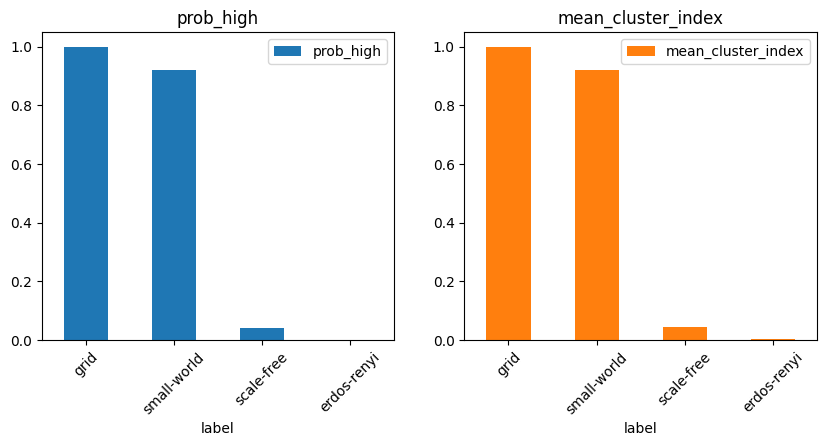

In [28]:
ax = topology_df.plot(
    x="label",
    y=["prob_high", "mean_cluster_index"],
    kind="bar",
    subplots=True,
    layout=(1, 2),
    figsize=(10, 4),
    rot=45,
    sharex=True,
)

In [29]:
X0_values = np.linspace(0.0, 1.0, 25)
I0_values = np.linspace(0.0, 1.0, 25)

for label, cfg in network_configs.items():
    phase_df = phase_sweep_df_I0(
        X0_values=X0_values,
        I0_values=I0_values,
        scenario_kwargs={
            "network_type": cfg["network_type"],
            "n_nodes": cfg["n_nodes"],
            "p": cfg["p"],
            "m": cfg["m"],
        },
        batch_size=8,          # reduce if it’s slow
        T=200,
        strategy_choice_func="imitate",
        tau=1.0,
    )
    png_path = plot_phase_plot_I0_networks(phase_df, out_path=None)
    print(label, "phase plot saved to:", png_path)


grid phase plot saved to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\ev_phase_plot_I0_1.png
small-world phase plot saved to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\ev_phase_plot_I0_2.png
scale-free phase plot saved to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\ev_phase_plot_I0_3.png
erdos-renyi phase plot saved to: c:\Users\leonc\mbd-notebooks\Model-Based-Decisions-Code_2\Assignment 3\plots\ev_phase_plot_I0_4.png


In [30]:
for label, cfg in network_configs.items():
    phase_df = phase_sweep_df_I0(
        X0_values=X0_values,
        I0_values=I0_values,
        scenario_kwargs={
            "network_type": cfg["network_type"],
            "n_nodes": cfg["n_nodes"],
            "p": cfg["p"],
            "m": cfg["m"],
        },
        batch_size=6,
    )
    tip_X0 = tipping_X0(phase_df, I0_target=0.2)
    print(label, "tipping X0 at I0≈0.2:", tip_X0)

grid tipping X0 at I0≈0.2: 0.125
small-world tipping X0 at I0≈0.2: 0.16666666666666666
scale-free tipping X0 at I0≈0.2: 0.5
erdos-renyi tipping X0 at I0≈0.2: 0.3333333333333333
